# チューニングのポイント　その２

### 実行前処理

In [ ]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [2]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# 乱数の種
random_seed = 123

#### サンプルデータの読み込み

In [3]:
# サンプルデータの読み込み
# (乳がん疾患データ)

# データのロード
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# 入力データ: x (30次元)
# 正解データ: y
x = cancer.data
y = cancer.target

In [ ]:
# サンプルデータの分割

# データ分割のパラメータ
test_size = 0.1

# データ分割
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
    test_size=test_size, random_state=random_seed,
    stratify=y)

# 分割後サイズ確認
print(x.shape)
print(x_train.shape)
print(x_test.shape)

## チューニングのポイント3　交差検定法

データをいくつかに分割して、学習とテストを繰返し、そのスコアの平均を出す方法を交差検証法といいます。

複数のアルゴリズムを交差検証法にかけて、検証を行わなかった場合との比較をしてみたいと思います。

<交差検証法のイメージ>
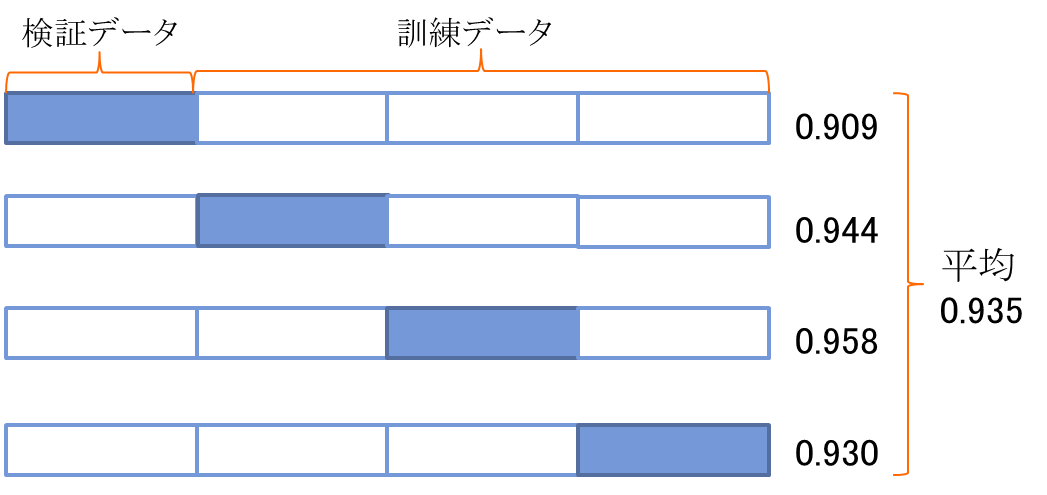

In [ ]:
# 特定のアルゴリズムに対して交差検定を実施
from sklearn.svm import SVC

# アルゴリズムの定義
algorithm = SVC(kernel='rbf',random_state=random_seed,
    gamma=0.001, C=1)

# 分割時に正解データの分布が偏らないようにStratifiedKFoldを利用
from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

# 交差検定の実施 (分割数=3)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(algorithm , x_train, y_train, 
    cv=stratifiedkfold)

# 平均値の計算
mean = scores.mean()

# 結果表示
print(f'平均スコア: {mean:.4f}  個別スコア: {scores}')

In [6]:
# 候補アルゴリズムのリスト作成

from sklearn.linear_model import LogisticRegression
algorithm1 = LogisticRegression(random_state=random_seed)

algorithm2 = SVC(kernel='rbf',random_state=random_seed,
    gamma=0.001, C=1)

# ニューラルネットワーク　
from sklearn.neural_network import MLPClassifier
algorithm3 = MLPClassifier(hidden_layer_sizes=(100,100), random_state=random_seed)

from sklearn.tree import DecisionTreeClassifier
algorithm4 = DecisionTreeClassifier(random_state=random_seed)

from sklearn.ensemble import RandomForestClassifier
algorithm5 = RandomForestClassifier(random_state=random_seed)

from xgboost import XGBClassifier
algorithm6 = XGBClassifier(random_state=random_seed)

algorithms = [algorithm1, algorithm2, algorithm3, algorithm4, 
    algorithm5, algorithm6]

In [ ]:
# 複数アルゴリズムで精度比較
for algorithm in algorithms:
    
    # 訓練データで学習
    algorithm.fit(x_train, y_train)
    
    # 検証データで精度測定
    score = algorithm.score(x_test, y_test)
    
    # アルゴリズム名取得
    name = algorithm.__class__.__name__

    # 精度とアルゴリズム名表示
    print(f'スコア: {score:.4f}  {name}')

In [ ]:
# 複数アルゴリズムで精度を比較

# 分割時に正解データの分布が偏らないようにStratifiedKFoldを利用
from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

from sklearn.model_selection import cross_val_score
for algorithm in algorithms:
    # 交差検定法の実行
    scores = cross_val_score(algorithm , x_train, y_train, 
        cv=stratifiedkfold)
    score = scores.mean()
    name = algorithm.__class__.__name__
    print(f'平均スコア: {score:.4f}  個別スコア: {scores}  {name}')

## チューニングのポイント4　グリッド/ランダム/ベイズ
ハイパーパラメータの値を1つずつ想像してリストを作ってループを回わすのはとても効率が悪いです。複数のハイパーパラメータを同時に変更して最適化を図る方法を紹介し、使い分けられるようになるとチューニングの幅も広がるので紹介します。

### グリットリサーチ
調整する複数のパラメータの調整値のリストを作成し、
それをマトリクスにして組み合わせをすべて検証して最適値を見つける方法です。検証するパラメータが増えると時間がかかります。先ほどチューニングしたサポートベクターカーネルを例に挙げて確認します。

In [9]:
# 混同行列表示用関数
def make_cm(matrix, columns):
     # matrix numpy配列

    # columns 項目名リスト
    n = len(columns)

    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n
    
    #データフレーム生成
    cm = pd.DataFrame(matrix,
         columns=[pred, columns], index=[act, columns])
    return cm

In [ ]:
# グリッドサーチと交差検定を組み合わせて最適なパラメータを探索
params = {
    'C' : [0.1, 1, 10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 2.0]
}
algorithm = SVC(random_state=random_seed)

from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(algorithm, params, cv=stratifiedkfold)
gs.fit(x_train, y_train)

# ベストのモデルを取得し検証データを分類
best = gs.best_estimator_
best_pred = best.predict(x_test)
print(best)

In [ ]:
# 精度の取得
score = best.score(x_test, y_test)
print(f'スコア: {score:.4f}')

# 混同行列を出力
from sklearn.metrics import confusion_matrix
print()
print('混同行列')
make_cm(confusion_matrix(y_test, best_pred),['良性','悪性'])

### ランダムリサーチ

指定したパラメータの値をランダムに変更して最適値を見つける方法です。回数を指定可能です。先ほどチューニングしたサポートベクターカーネルを例に挙げて確認します。

In [ ]:
from scipy import stats
# ランダムサーチと交差検定を組み合わせて最適なパラメータを探索
#指数分布をつかって
params = {
    'C' : [0.1, 1, 10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 2.0]
}

algorithm = SVC(random_state=random_seed)

from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(algorithm, params, cv=stratifiedkfold)
rs.fit(x_train, y_train)

# ベストのモデルを取得し検証データを分類
best = rs.best_estimator_
best_pred = best.predict(x_test)
print(best)

In [ ]:
# 精度の取得
score = best.score(x_test, y_test)
print(f'スコア: {score:.4f}')

# 混同行列を出力
from sklearn.metrics import confusion_matrix
print()
print('混同行列')
make_cm(confusion_matrix(y_test, best_pred),['良性','悪性'])

### ベイズ最適化

ベイズ推定を利用してパラメータの値を調整しながら最適値を見つける方法です。先ほどチューニングしたサポートベクターカーネルを例に挙げて確認します。

In [ ]:
pip install scikit-optimize

In [ ]:
from skopt.space import Real, Categorical, Integer
#------ベイズ最適化-----------#
params = {
    'C' : [0.1, 1, 10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 2.0]
}

algorithm = SVC(random_state=random_seed)

from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

from skopt import BayesSearchCV
bs = BayesSearchCV(algorithm, params, cv=stratifiedkfold, n_iter = 30)
bs.fit(x_train, y_train)

# ベストのモデルを取得し検証データを分類
best = bs.best_estimator_
best_pred = best.predict(x_test)
print(best)

In [ ]:
# 精度の取得
score = best.score(x_test, y_test)
print(f'スコア: {score:.4f}')

# 混同行列を出力
from sklearn.metrics import confusion_matrix
print()
print('混同行列')
make_cm(confusion_matrix(y_test, best_pred),['良性','悪性'])